In [7]:
import os
import shutil
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import timm
import numpy as np
import time

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 10  
model = timm.create_model('davit_small', pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load('davit_model.pth'))
model = model.to(device)
model.eval()

DaVit(
  (stem): Stem(
    (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    (norm): LayerNorm2d((96,), eps=1e-05, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): DaVitStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): Sequential(
          (0): SpatialBlock(
            (cpe1): ConvPosEnc(
              (proj): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
              (act): Identity()
            )
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (cpe2): ConvPosEnc(
              (proj): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
              

In [9]:
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load validation dataset
val_dataset = datasets.ImageFolder(root='D:\\CVPI\\Dataset\\validation', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [10]:
all_preds = []
all_labels = []
misclassified_path = []

# Start timer
start_time = time.time()

# Cell 5: Evaluation loop
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc="Evaluating", unit="batch")):
        images, labels = images.to(device), labels.to(device)
        preds = model(images).argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        for idx in range(len(labels)):
            if preds[idx] != labels[idx]:
                img_path = val_dataset.imgs[batch_idx * val_loader.batch_size + idx][0]
                misclassified_path.append(img_path)

Evaluating:   0%|                                                                          | 0/2017 [00:00<?, ?batch/s]C:\Users\Dhruv\AppData\Roaming\Python\Python312\site-packages\timm\models\davit.py:305: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(q, k, v)
Evaluating: 100%|███████████████████████████████████████████████████████████████| 2017/2017 [03:45<00:00,  8.94batch/s]


Time taken to process all images: 225.66 seconds
Confusion Matrix:
[[  414     5    42     4     2     0    26     4     0     0]
 [    7   302    35     5     0     1     4     5     0     0]
 [   25    20   954    39    16     6    77    12     6     0]
 [    6     3    56   196     2     1    16    17     0     0]
 [    2     0    14     4   302     0    13     5     0     0]
 [    5     1     8     0     2   301    20     6     0     0]
 [   16     7    66    11     8    16 12128    35     0     0]
 [    6     4    27    30     8     4    55   366     0     0]
 [    1     0     8     0     0     0     6     0   271     0]
 [    0     0     0     0     0     0     0     0     0    68]]


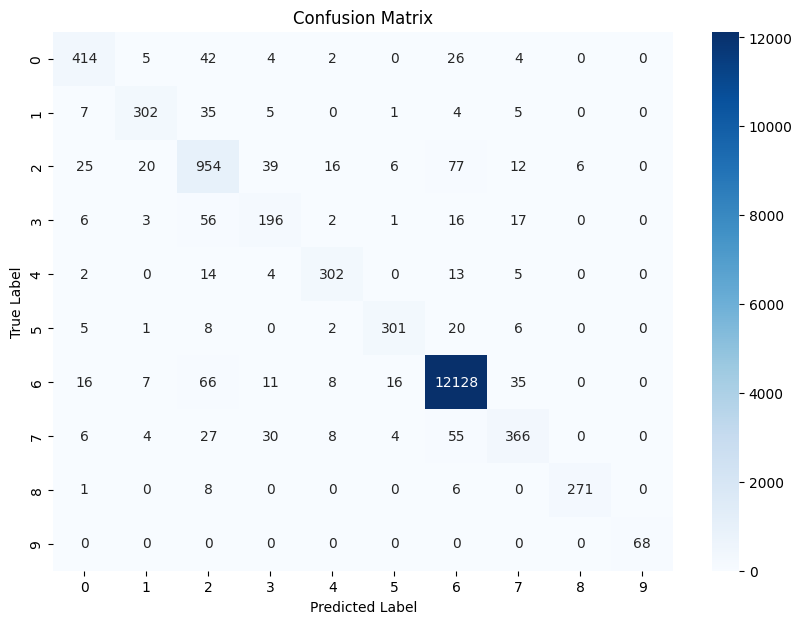

In [11]:
conf_matrix = confusion_matrix(all_labels, all_preds)

# Stop timer and compute elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to process all images: {elapsed_time:.2f} seconds")
print("Confusion Matrix:")
print(conf_matrix)

# Cell 7: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_preds), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9483
Recall: 0.9485
F1 Score: 0.9483


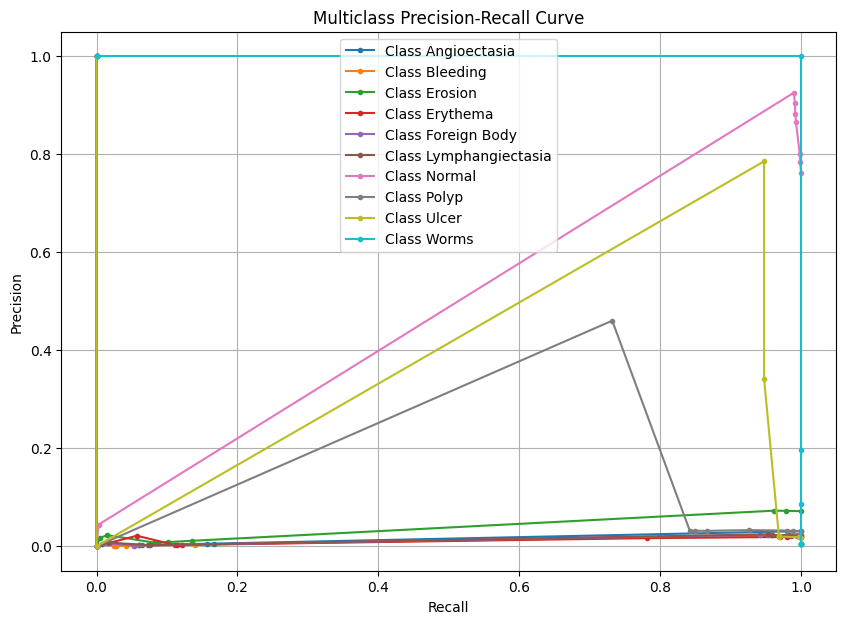

In [13]:
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 
               'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

y_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))

plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], all_preds)
    plt.plot(recall, precision, marker='.', label=f'Class {class_names[i]}')

plt.title('Multiclass Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

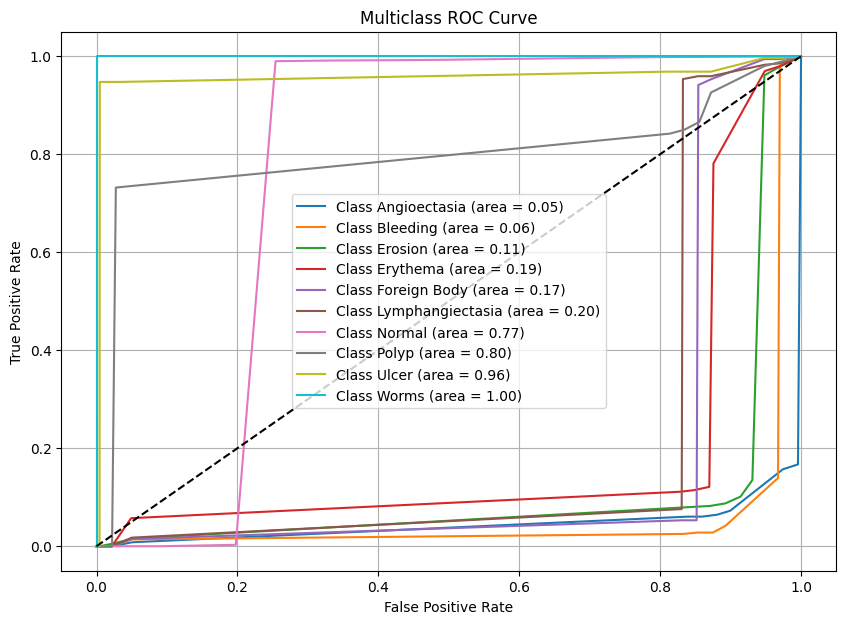

In [14]:
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


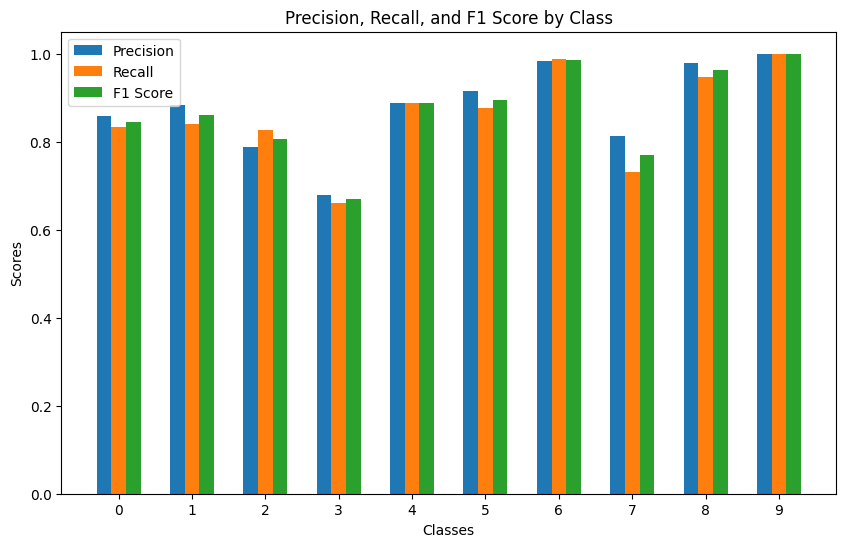

In [15]:
report = classification_report(all_labels, all_preds, output_dict=True)

precision = []
recall = []
f1 = []
class_names = []

for class_name in report.keys():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        precision.append(report[class_name]['precision'])
        recall.append(report[class_name]['recall'])
        f1.append(report[class_name]['f1-score'])
        class_names.append(class_name)

precision = np.array(precision)
recall = np.array(recall)
f1 = np.array(f1)

# Create a bar graph
x = np.arange(len(class_names))
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1, width, label='F1 Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

plt.show()

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Example class names
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 
               'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

# Binarize the output labels
y_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))

# Initialize a figure
plt.figure(figsize=(10, 7))

# Loop through each class to calculate and plot Precision-Recall
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], all_preds[:, i])  # Use probabilities for precision-recall calculation

    # Plotting each class's Precision-Recall curve
    plt.plot(recall, precision, marker='.', label=f'Class {class_names[i]}')

# Adding labels and title
plt.title('Multiclass Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


TypeError: list indices must be integers or slices, not tuple

<Figure size 1000x700 with 0 Axes>